In [249]:
import geopandas as gpd
import os
import xarray as xr
import numpy as np
import pandas as pd
import copy
import pickle
import gc
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#import leafmap
import leafmap.foliumap as leafmap
from shapely.geometry import mapping
import pyproj


In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

In [3]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [4]:
big_pv_geoms = gpd.read_file(f"{data_dir}/germany_photovoltaic.shp")

In [5]:
# Filter the data to have farms bigger then 5 km2
big_pv_geoms_32632 = big_pv_geoms.to_crs(32632)
big_pv_geoms_32632_buffer_20 = copy.deepcopy(big_pv_geoms_32632)
big_pv_geoms_32632_buffer_20["geometry"] = [i.buffer(20) for i in big_pv_geoms_32632_buffer_20.geometry]
big_pv_geoms_buffer = big_pv_geoms_32632_buffer_20.to_crs(4326)


print(f"Number of selected PV Farms: {len(big_pv_geoms_buffer)}")

Number of selected PV Farms: 4458


In [6]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

### Extract the data and save them as numpy arrays
Run this section just for the first time

In [5]:
for i, geom in big_pv_geoms_buffer.iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
        
        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        #data_filled['crs'] = data.crs
        data.rio.write_crs("epsg:32633", inplace=True) #32633

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)

        ## Clip the farm polygon
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        break        
    except:
         print(f"This polygon id: {i} is not exist.")

This polygon id: 0 is not exist.
This polygon id: 1 is not exist.


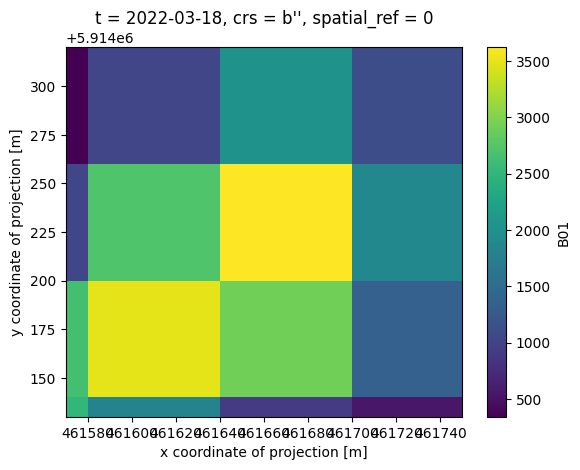

In [6]:
data['B01'][30].plot()

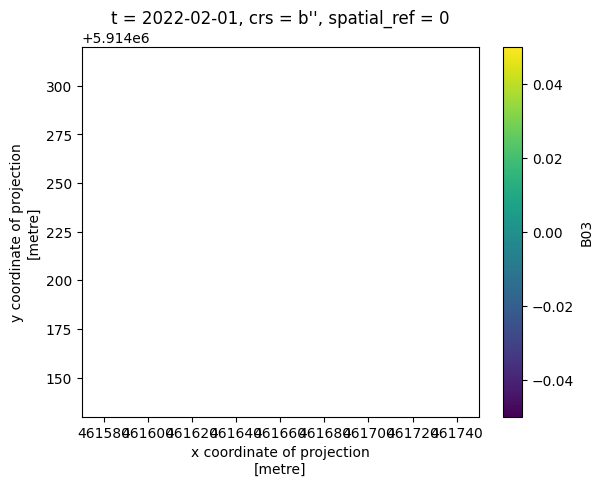

In [8]:
clipped['B03'][12].plot()

In [ ]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[280:].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 280 is not exist.
This polygon id: 282 is not exist.
This polygon id: 284 is not exist.
This polygon id: 287 is not exist.
This polygon id: 288 is not exist.
This polygon id: 294 is not exist.
This polygon id: 307 is not exist.
This polygon id: 308 is not exist.
This polygon id: 315 is not exist.
This polygon id: 328 is not exist.
This polygon id: 342 is not exist.
This polygon id: 344 is not exist.
This polygon id: 348 is not exist.
This polygon id: 350 is not exist.
This polygon id: 351 is not exist.
This polygon id: 353 is not exist.
This polygon id: 356 is not exist.
This polygon id: 365 is not exist.
This polygon id: 375 is not exist.
This polygon id: 376 is not exist.
This polygon id: 377 is not exist.
This polygon id: 386 is not exist.
This polygon id: 390 is not exist.
This polygon id: 400 is not exist.
This polygon id: 403 is not exist.
This polygon id: 414 is not exist.
This polygon id: 422 is not exist.
This polygon id: 424 is not exist.
This polygon id: 425

In [ ]:
pv_samples = np.vstack(all_pixels_ts)
pv_samples.shape

In [ ]:
y1 = np.ones(pv_samples.shape[0])

In [24]:
print(pv_samples.shape)
print(y1.shape)

(490597, 11, 365)
(490597,)


In [25]:
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy', pv_samples)

In [9]:
# Extract S2 data for the photvoltaic farms - pixels outside the polygons "labels as 0"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[280:1500].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633

        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=True)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 280 is not exist.
This polygon id: 282 is not exist.
This polygon id: 284 is not exist.
This polygon id: 287 is not exist.
This polygon id: 288 is not exist.
This polygon id: 294 is not exist.
This polygon id: 307 is not exist.
This polygon id: 308 is not exist.
This polygon id: 315 is not exist.
This polygon id: 328 is not exist.
This polygon id: 342 is not exist.
This polygon id: 344 is not exist.
This polygon id: 348 is not exist.
This polygon id: 350 is not exist.
This polygon id: 351 is not exist.
This polygon id: 353 is not exist.
This polygon id: 356 is not exist.
This polygon id: 365 is not exist.
This polygon id: 375 is not exist.
This polygon id: 376 is not exist.
This polygon id: 377 is not exist.
This polygon id: 386 is not exist.
This polygon id: 390 is not exist.
This polygon id: 400 is not exist.
This polygon id: 403 is not exist.
This polygon id: 414 is not exist.
This polygon id: 422 is not exist.
This polygon id: 424 is not exist.
This polygon id: 425

In [ ]:
non_pv_samples = np.vstack(all_pixels_ts)
non_pv_samples.shape

In [ ]:
y0 = np.zeros(non_pv_samples.shape[0])

In [ ]:
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy', non_pv_samples)

#### Combine both PV and Non-PV togehter 

In [10]:
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy')
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy')

In [11]:
y1 = np.zeros(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])

In [12]:
print(pv_samples.shape)
print(non_pv_samples.shape)

print(y1.shape)
print(y0.shape)

(490597, 11, 365)
(320803, 11, 365)
(490597,)
(320803,)


In [13]:
tr_data = np.vstack([pv_samples, non_pv_samples])
y = np.hstack([y1, y0])

In [14]:
print(tr_data.shape)
print(y.shape)

(498597, 11, 365)
(498597,)


### Modeling

In [8]:
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy')
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy')

y1 = np.ones(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])

tr_data = np.vstack([pv_samples, non_pv_samples])
y = np.hstack([y1, y0])

In [9]:
del non_pv_samples, pv_samples, y1, y0 ; gc.collect()

496

In [10]:
tr_data = np.nan_to_num(tr_data, nan=-999999)

In [11]:
tr_data = tr_data.reshape(tr_data.shape[0], tr_data.shape[1]*tr_data.shape[2])
tr_data.shape

(811400, 4015)

In [12]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
scores = []
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=2024)
    clf.fit(x_train, y_train)
    
    
    # Validation
    y_pred = clf.predict(x_val)
    score = accuracy_score(y_pred, y_val)
    scores.append(score)
    print(f'Accuracy Score: {score}')
    
    filename = f'../models/non_temporal_models/rf_non_temporal_{i+1}.sav'
    pickle.dump(clf, open(filename, 'wb'))
    
    i+=1
    break
print(f'Average F1 Score: {np.mean(scores)}')

########### Fold number 1 
Accuracy Score: 0.8558232684249445
Average F1 Score: 0.8558232684249445


In [13]:
del tr_data, x_train, x_val, y_train, y_val; gc.collect()

0

### Inference  

#### Extrac the dataset 
Run it for the first time

In [27]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[:280].iterrows(): #280
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')
        
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1)) 
        #break
    
    except:
        print(f"This polygon id: {i} is not exist.")


This polygon id: 0 is not exist.
This polygon id: 1 is not exist.
This polygon id: 6 is not exist.
This polygon id: 9 is not exist.
This polygon id: 17 is not exist.
This polygon id: 27 is not exist.
This polygon id: 29 is not exist.
This polygon id: 56 is not exist.
This polygon id: 62 is not exist.
This polygon id: 65 is not exist.
This polygon id: 69 is not exist.
This polygon id: 74 is not exist.
This polygon id: 84 is not exist.
This polygon id: 87 is not exist.
This polygon id: 97 is not exist.
This polygon id: 99 is not exist.
This polygon id: 103 is not exist.
This polygon id: 107 is not exist.
This polygon id: 118 is not exist.
This polygon id: 124 is not exist.
This polygon id: 130 is not exist.
This polygon id: 138 is not exist.
This polygon id: 140 is not exist.
This polygon id: 143 is not exist.
This polygon id: 170 is not exist.
This polygon id: 171 is not exist.
This polygon id: 177 is not exist.
This polygon id: 184 is not exist.
This polygon id: 186 is not exist.
This 

In [30]:
te_pv_samples = np.vstack(all_pixels_ts)
te_pv_samples = np.nan_to_num(te_pv_samples, nan=-999999)

In [31]:
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/te_pv_samples.npy', te_pv_samples)

In [32]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[:280].iterrows(): #280
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')
        
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=True)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1)) 
        #break
    
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 0 is not exist.
This polygon id: 1 is not exist.
This polygon id: 6 is not exist.
This polygon id: 9 is not exist.
This polygon id: 17 is not exist.
This polygon id: 27 is not exist.
This polygon id: 29 is not exist.
This polygon id: 56 is not exist.
This polygon id: 62 is not exist.
This polygon id: 65 is not exist.
This polygon id: 69 is not exist.
This polygon id: 74 is not exist.
This polygon id: 84 is not exist.
This polygon id: 87 is not exist.
This polygon id: 97 is not exist.
This polygon id: 99 is not exist.
This polygon id: 103 is not exist.
This polygon id: 107 is not exist.
This polygon id: 118 is not exist.
This polygon id: 124 is not exist.
This polygon id: 130 is not exist.
This polygon id: 138 is not exist.
This polygon id: 140 is not exist.
This polygon id: 143 is not exist.
This polygon id: 170 is not exist.
This polygon id: 171 is not exist.
This polygon id: 177 is not exist.
This polygon id: 184 is not exist.
This polygon id: 186 is not exist.
This 

In [33]:
te_non_pv_samples = np.vstack(all_pixels_ts)
te_non_pv_samples = np.nan_to_num(te_non_pv_samples, nan=-999999)
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/te_non_pv_samples.npy', te_non_pv_samples)

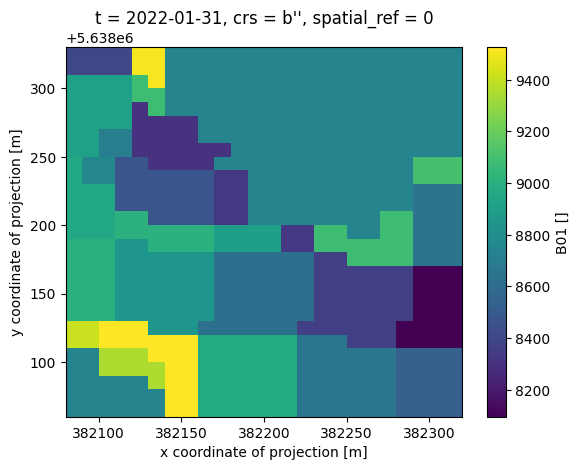

In [18]:
ds_daily_interp['B01'][30].plot()

In [19]:
## Clip the farm polygon - We do not crop it here cuz we need to classifiy all the pixels 
clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

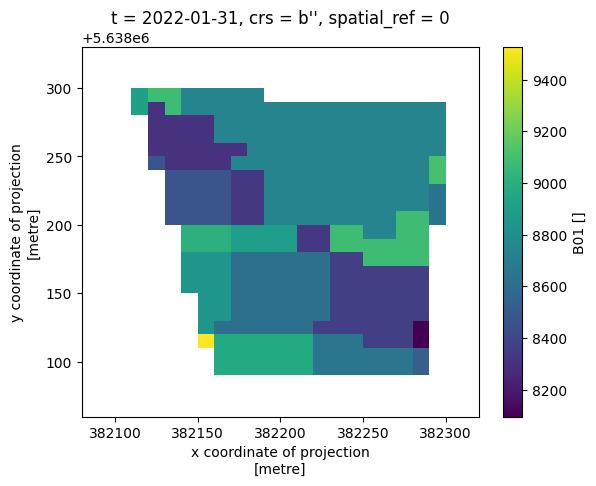

In [20]:
clipped['B01'][30].plot()

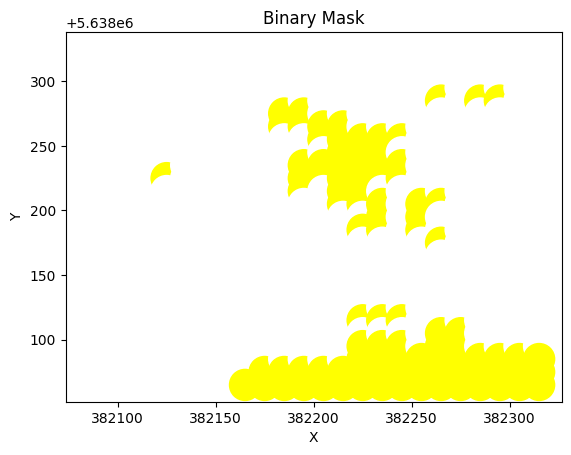

In [26]:
custom_cmap = ListedColormap(['white', 'yellow']) #yellow for 1 and white for 0

# Plot the binary mask
plt.scatter(x, y, c=te_pred, cmap=custom_cmap, s=500)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Mask')
plt.show()

#### Inference

In [6]:
te_non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_non_pv_samples.npy')
te_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_pv_samples.npy')

y1 = np.ones(te_pv_samples.shape[0])
y0 = np.zeros(te_non_pv_samples.shape[0])

In [7]:
te_data = np.vstack([te_pv_samples, te_non_pv_samples])
y_test = np.hstack([y1, y0])

In [8]:
te_samples = te_data.reshape(te_data.shape[0], te_data.shape[1]*te_data.shape[2])
te_samples.shape

(380403, 4015)

In [9]:
clf = pickle.load(open(f'../models/non_temporal_models/rf_non_temporal_1.sav', 'rb'))

In [10]:
te_pred = clf.predict(te_samples)

In [13]:
test_score = accuracy_score(te_pred, y_test)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.7340399523663063


In [16]:
te_pv_samples = te_pv_samples.reshape(te_pv_samples.shape[0], te_pv_samples.shape[1]*te_pv_samples.shape[2])


te_pred = clf.predict(te_pv_samples)

test_score = accuracy_score(te_pred, y1)
print(f'Test Accuracy Score for PV pixels: {test_score}')

Test Accuracy Score for PV pixels: 0.8237583892617449


#### This is for plotting

In [24]:
df_normal = df.reset_index()
x = df_normal[['x', 'y']].values[:,0]
y = df_normal[['x', 'y']].values[:,1]

In [25]:
te_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Leaf map

In [227]:
clf = pickle.load(open(f'../models/non_temporal_models/rf_non_temporal_1.sav', 'rb'))

In [136]:
leafmap.search_qms(keyword="google")

['qms.basemap.at',
 'qms.basemap.at Orthofoto',
 'qms.EOX::Maps - Sentinel-2 cloudless',
 'qms.Geoland Basemap',
 'qms.Geoland Basemap Gelände',
 'qms.Geoland Basemap Grau',
 'qms.Geoland Basemap High DPI',
 'qms.Geoland Basemap Oberfläche',
 'qms.Geoland Basemap Orthofoto',
 'qms.Geoland Basemap Overlay']

In [228]:
def json_s2_boundary(coords):
    bounds = (
        float(coords['x'].min()),  # minx
        float(coords['y'].min()),  # miny
        float(coords['x'].max()),  # maxx
        float(coords['y'].max())   # maxy
    )
    
    # Define the bounds
    minx, miny, maxx, maxy = bounds
    
    # Define the coordinates for the rectangle
    rectangle_coords = [
        [ minx, miny],
        [maxx,miny],
        [maxx, maxy],
        [minx, maxy],
        [minx, miny]  
        
    ]
    
    
    # Create a GeoJSON object for the rectangle
    rectangle_geojson = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [rectangle_coords]
                },
                "properties": {}
            }
        ]
    }
    
    return rectangle_geojson


In [240]:
def extract_test_data(farm_id):
    start_date = '2022-01-01'
    end_date = '2022-12-31'
    
    all_pixels_ts = []
    
    geom = big_pv_geoms_buffer.iloc[farm_id]
    farm_id = geom.name
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{farm_id}.nc",decode_coords="all")
        coords = data.rio.reproject("EPSG:4326").coords
        s2_boundaries = json_s2_boundary(coords)
        
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')
        
        #clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = ds_daily_interp.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            #df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1)) 
        te_samples = np.vstack(all_pixels_ts)
        te_samples = np.nan_to_num(te_samples, nan=-999999)

        
        te_samples = te_samples.reshape(te_samples.shape[0], te_samples.shape[1]*te_samples.shape[2])
        df_normal = df_b.reset_index()
        x_coords = df_normal[['x', 'y']].values[:,0]
        y_coords = df_normal[['x', 'y']].values[:,1]


        return te_samples, x_coords, y_coords, s2_boundaries
    
    except:
        print(f"This farm : {farm_id} is not exist.")  
        

In [250]:
def farm_plot(farm_id, s2_boundaries):
    geom_wgs84 = big_pv_geoms_buffer.iloc[farm_id]
    centroid = geom_wgs84.geometry.centroid
    
    # Add the PV farm boundaries
    ## Convert the polygon boundary to GeoJSON format
    geojson_farm = mapping(geom_wgs84.geometry)    
    m = leafmap.Map(center=[centroid.y, centroid.x], zoom=15)
    m.add_xyz_service("qms.EOX::Maps - Sentinel-2 cloudless")
    folium.GeoJson(geojson_farm).add_to(m)
    
    # Add s2 boundaries
    folium.GeoJson(s2_boundaries).add_to(m)
    
    return m, geojson_farm

In [243]:
# Input the farm id in the GDF
te_samples, x_coords, y_coords, s2_boundaries = extract_test_data(farm_id = 278)
te_samples.shape

(4851, 4015)

In [251]:
m, geojson_farm = farm_plot(farm_id = 278, s2_boundaries = s2_boundaries)
m

In [247]:
# Predictions 
te_pred = clf.predict(te_samples)
te_pred

array([0., 0., 0., ..., 0., 0., 0.])

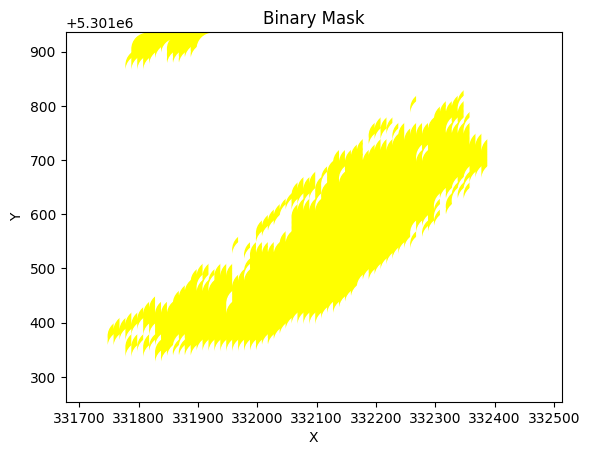

In [248]:
custom_cmap = ListedColormap(['white', 'yellow']) #yellow for 1 and white for 0

# Plot the binary mask
plt.scatter(x_coords, y_coords, c=te_pred, cmap=custom_cmap, s=500)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Mask')
plt.show()

In [254]:
def map_predictios(te_pred,x_coords, y_coords, geojson_farm, s2_boundaries):
    # Define the original CRS 
    original_crs = pyproj.CRS("EPSG:32633") 
    
    # Define the target CRS (WGS84)
    target_crs = pyproj.CRS("EPSG:4326")
    
    # Create a pyproj transformer to perform the coordinate transformation
    transformer = pyproj.Transformer.from_crs(original_crs, target_crs, always_xy=True)
    
    # Transform coordinates from the original CRS to WGS84
    lon, lat = transformer.transform(x_coords, y_coords)
    
    # Create a map centered at the mean of coordinates
    min_x, max_x = np.min(lon), np.max(lon)
    min_y, max_y = np.min(lat), np.max(lat)
    center = [(min_y + max_y) / 2, (min_x + max_x) / 2]
    m = leafmap.Map(location=center, zoom_start=15)
    m.add_xyz_service("qms.EOX::Maps - Sentinel-2 cloudless")
    
    # Add farm boundaries
    folium.GeoJson(geojson_farm).add_to(m)
    
    # Add s2 boundaries
    folium.GeoJson(s2_boundaries).add_to(m)
    
    # Iterate over each point in the array
    for x, y, value in zip(lon, lat, te_pred):
        # Add a marker with color based on the value
        if value == 1:
            folium.CircleMarker(
                location=[y, x],  # Note the order: [latitude, longitude]
                radius=5,
                color='red',
                fill=True,
                fill_color='red'
            ).add_to(m)
            
            
    return m
        

In [255]:
map_predictios(te_pred,x_coords, y_coords, geojson_farm, s2_boundaries)